In [286]:
import pandas as pd
df = pd.read_pickle('results.pkl')

In [288]:
df

KeyboardInterrupt: 

# Sampling from the version space

Let's consider a simple example where we have access to the true rules that generated the data. We can build a dataset that is generated by these rules and then build the version space, that is, a set of all possible rules that could have generated the data. We can then compute the expected performance from this version space with different techniques and see how classification performance changes.

We consider the following ground truth rule set (i.e., a DNF).

$$(x_0=0 \wedge x_1=1 \wedge x_3=0) \vee (x_2=1 \wedge x_4=1)$$

We consider as hypothesis space the set of m-terms k-DNF, that is, all possible combinations **up to** $k$ different conjunctive rules put in OR, where each rule is a conjunction of **at most** $m$ features.

For example, the chosen DNF is a 3-term 2-DNF. Instead, a 2-term 2-DNF could be $x_0=0 \wedge x_1=1 \vee x_2=1$.


In [266]:
import math

from tqdm import tqdm

from bpllib.rules._discrete_constraint import DiscreteConstraint
from bpllib.rules._rule import Rule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# random rules
r1 = Rule(constraints={0: DiscreteConstraint(value=0, index=0),
                       1: DiscreteConstraint(value=1, index=1),
                       3: DiscreteConstraint(value=0, index=3)
                       })

r2 = Rule(constraints={2: DiscreteConstraint(value=1, index=2),
                       4: DiscreteConstraint(value=1, index=4)
                       }
          )

#r3 = Rule(constraints={5: DiscreteConstraint(value=1, index=5),
#                       6: DiscreteConstraint(value=0, index=6)})

rule_set = [r1, r2]  #, r3]


(note: I haven't used three ors, since to show that the weighted strategy is effective, I would have needed to consider all 4-DNFs as well)

## Generate data

We generate a dataset of all the possible samples. We use the same rules to generate the labels for both sets.

Each datapoint is in $\{0, 1\}^8$. The rules involve only the first 5 features, hence rules in the version space may have irrelevant features inside.

All the possible conjunctive rules involving 8 features and 3 terms are 576.

Later we will build the version space. To avoid unnecessary computation, we can already filter out the ones that cover any negative example. Of course, they will not be in the version space. We can't remove rules that don't cover any positive example, because they can still be in the version space.

In [268]:
import itertools


def generate_rules(m, n_features=7):
    all_features = list(range(n_features))
    combos = itertools.combinations(all_features, m)
    rules = set()
    for combo in combos:
        for combo_values in itertools.product([0, 1], repeat=m):
            rule = Rule(constraints={})
            for i in range(m):
                if combo_values[i] == 0:
                    rule.constraints[combo[i]] = DiscreteConstraint(value=0, index=combo[i])
                else:
                    rule.constraints[combo[i]] = DiscreteConstraint(value=1, index=combo[i])
            rules.add(rule)
    return rules


full_rule_space = set.union(*[generate_rules(m=m, n_features=8) for m in range(1, 4)])

print(len(full_rule_space))



576


The full rule space would be given by the power set of the features.

$$\mathcal{P}(\{x_i=v_j | i \in \{1, d\}, v_j \in \{0, 1\} \})$$

where $x_i$ is the $i$-th feature and $v_j$ is the $j$-th value of the feature.

Down the line, this is a source of combinatorial explosion.  Hence, we restrict the hypothesis space to a maximum number of features (terms in a DNF) $m$.


In [269]:
def generate_tuples_async(k, rule_space):
    for i in range(1, k + 1):
        tuples = itertools.combinations(rule_space, i)

        for t in tuples:
            yield t

In [270]:
def filter_rule_space(X, y, full_rule_space):
    # exclude all rules that cover at least one negative example
    neg = X[y == 0]
    for rule in full_rule_space:
        if not any([rule.covers(x) for x in neg]):
            yield rule

In [271]:
def create_X(n=8):
    # create all combinations of N features
    from itertools import product
    combinations = list(product([0, 1], repeat=n))  # generate all binary combinations of length n
    X = np.array(combinations)
    return X


X = create_X(8)

In [272]:
y = np.array([any([r.covers(x) for r in rule_set]) for x in X])

print("prop. pos/all:", y.sum() / len(y))

frs = list(filter_rule_space(X, y, full_rule_space))
print(len(frs))

prop. pos/all: 0.34375
14


In [273]:
def generate_version_space(X, y, full_rule_space, k=3, verbose=False):
    VS = set()
    rule_space = list(filter_rule_space(X, y, full_rule_space))
    if verbose:
        print("rule space len (after filter):", len(rule_space))
    from tqdm import tqdm

    it = generate_tuples_async(k, rule_space)
    tot = sum([math.comb(len(rule_space), i) for i in range(1, k + 1)])
    if verbose or tot > 1e5:
        it = tqdm(it, total=tot)

    for h in it:
        ok = True

        for x in X[y == 0]:
            if any([r.covers(x) for r in h]):
                ok = False
                break
        for x in X[y == 1]:
            if not any([r.covers(x) for r in h]):
                ok = False
                break

        if ok:
            VS.add(h)
    return VS

In [274]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)
VS = generate_version_space(X_train, y_train, full_rule_space, k=4)
len(VS)

486

In [275]:
sorted(VS, key=lambda x: len(x) + sum([len(r) for r in x]) / 1000)[:20]

[(X[2] == 1 ^ X[4] == 1, X[0] == 0 ^ X[1] == 1 ^ X[3] == 0),
 (X[2] == 1 ^ X[4] == 1,
  X[2] == 1 ^ X[4] == 1 ^ X[6] == 0,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0),
 (X[2] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0,
  X[2] == 1 ^ X[4] == 1 ^ X[6] == 1),
 (X[2] == 1 ^ X[3] == 0 ^ X[5] == 0,
  X[2] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0),
 (X[2] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0,
  X[1] == 1 ^ X[2] == 1 ^ X[4] == 1),
 (X[2] == 1 ^ X[4] == 1 ^ X[7] == 0,
  X[2] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0),
 (X[2] == 1 ^ X[4] == 1,
  X[2] == 1 ^ X[3] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0),
 (X[2] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0,
  X[0] == 1 ^ X[2] == 1 ^ X[4] == 1),
 (X[2] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0,
  X[2] == 1 ^ X[3] == 0 ^ X[6] == 1),
 (X[2] == 1 ^ X[4] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[3] == 0,
  X[0] == 0 ^ X[2] == 1 ^ X[4] == 1),
 (X[2] == 1 ^ X[4] == 1,
  X[2] == 1 ^ 

Here we can see the rules found. The shortest rule is the correct one (the one that generated the data),

`(X[2] == 1 ^ X[4] == 1, X[0] == 0 ^ X[1] == 1 ^ X[3] == 0)`

But we can also find many other different, valid DNFs, that are more specific and more complex.

If we change the training size to make it smaller, we can find more general DNFs that are still in the version space. These DNFs are not the correct one, but they still classify the training data with perfect accuracy.

Here, the following are more general.

```
(X[2] == 1 ^ X[4] == 1, X[0] == 0 ^ X[1] == 1),
(X[1] == 1 ^ X[2] == 1, X[0] == 0 ^ X[1] == 1)
```


In [227]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)
VS = generate_version_space(X_train, y_train, full_rule_space, k=3)
len(VS)
sorted(VS, key=lambda x: len(x) + sum([len(r) for r in x]) / 1000)[:20]

100%|██████████| 134137/134137 [00:05<00:00, 25971.69it/s]


[(X[2] == 1 ^ X[4] == 1, X[0] == 0 ^ X[1] == 1),
 (X[1] == 1 ^ X[2] == 1, X[0] == 0 ^ X[1] == 1),
 (X[1] == 1 ^ X[2] == 1, X[0] == 0 ^ X[1] == 1 ^ X[2] == 0),
 (X[2] == 1 ^ X[4] == 1 ^ X[7] == 1, X[0] == 0 ^ X[1] == 1),
 (X[0] == 0 ^ X[1] == 1, X[0] == 1 ^ X[2] == 1 ^ X[4] == 1),
 (X[0] == 0 ^ X[1] == 1, X[1] == 1 ^ X[2] == 1 ^ X[4] == 1),
 (X[2] == 1 ^ X[3] == 0 ^ X[4] == 1, X[0] == 0 ^ X[1] == 1),
 (X[1] == 1 ^ X[2] == 1 ^ X[7] == 1, X[0] == 0 ^ X[1] == 1),
 (X[1] == 1 ^ X[2] == 1, X[0] == 0 ^ X[2] == 0 ^ X[3] == 0),
 (X[0] == 0 ^ X[1] == 1, X[1] == 1 ^ X[2] == 1 ^ X[3] == 0),
 (X[0] == 0 ^ X[1] == 1, X[0] == 1 ^ X[1] == 1 ^ X[2] == 1),
 (X[0] == 1 ^ X[2] == 1 ^ X[3] == 0, X[0] == 0 ^ X[1] == 1),
 (X[2] == 1 ^ X[4] == 1, X[0] == 0 ^ X[1] == 1 ^ X[3] == 0),
 (X[1] == 1 ^ X[2] == 1, X[0] == 0 ^ X[1] == 1 ^ X[3] == 0),
 (X[0] == 1 ^ X[2] == 1 ^ X[7] == 1, X[0] == 0 ^ X[1] == 1),
 (X[1] == 1 ^ X[2] == 1 ^ X[7] == 1, X[0] == 0 ^ X[2] == 0 ^ X[3] == 0),
 (X[0] == 1 ^ X[2] == 1 ^ X[3] == 0,

We can observe the following:
* a priori, a simple rule set has less probability to be in the version space compared to a more complex one.

se pesco un ruleset a caso, è improbabile che sia semplice

* if a simple rule set is in the version space, then it is more probable that it is the correct one. (a posteriori)

## Uniform and weighted sampling

Here we implement the uniform sampling from the version space.

$$P(h) = \frac{1}{|VS|}$$

We also implement the weighted sampling, where the probability of a ruleset is proportional to the length of the ruleset, i.e., the number of ORs.

$$P(h) = \frac{e^{-\beta \ell(h)}}{\sum_{h' \in VS} e^{-\beta \ell(h')}}$$

We calculate the accuracy exactly, that is, in expectation w.r.t. the sampling process.

In [276]:
from sklearn.metrics import accuracy_score


def exact_uniform_bo(VS, X_test, y_test):
    y_pred = np.array([sum([(2 * any([r.covers(x) for r in h]) - 1) * (1 / len(VS)) for h in VS]) >= 0 for x in X_test])
    return accuracy_score(y_pred, y_test)

In [277]:
# print(exact_uniform_bp(VS, X_train, y_train))
print(exact_uniform_bo(VS, X_test, y_test))

1.0


In [278]:
from sklearn.metrics import accuracy_score


def exact_weighted_bo(VS, X_test, y_test, beta=1):
    y_pred = np.array(
        [sum([(2 * any([r.covers(x) for r in h]) - 1) * np.exp(-beta * len(h)) for h in VS]) >= 0 for x in X_test])
    return accuracy_score(y_pred, y_test)

In [279]:
print(exact_weighted_bo(VS, X_test, y_test, beta=10))

1.0


# Experiment 1
Firstly, let's see what happens by starting from a dataset X. We progressively increase the number of available training examples.


In [232]:
def get_X_y(X, y, seed=0, size=0.5):
    np.random.seed(seed)
    idx = np.random.permutation(len(X))
    X_perm = X[idx]
    y_perm = y[idx]

    X_train = X_perm[:int(size * len(X_perm))]
    y_train = y_perm[:int(size * len(X_perm))]
    X_test = X_perm[int(size * len(X_perm)):]
    y_test = y_perm[int(size * len(X_perm)):]
    return X_train, X_test, y_train, y_test

In [281]:
acc_bo = []
betas = [0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
acc_wbo = {beta: [] for beta in betas}

tr_sizes = [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4]
seed = 1


for training_size in tr_sizes:
    X_train, X_test, y_train, y_test = get_X_y(X, y, seed=seed, size=training_size)

    VS = generate_version_space(X_train, y_train, full_rule_space, k=3)
    bo_acc = exact_uniform_bo(VS, X_test, y_test)
    acc_bo.append(bo_acc)

    for beta in betas:
        wbo_acc = exact_weighted_bo(VS, X_test, y_test, beta=beta)
        acc_wbo[beta].append(wbo_acc)


100%|██████████| 134137/134137 [00:04<00:00, 29819.65it/s]


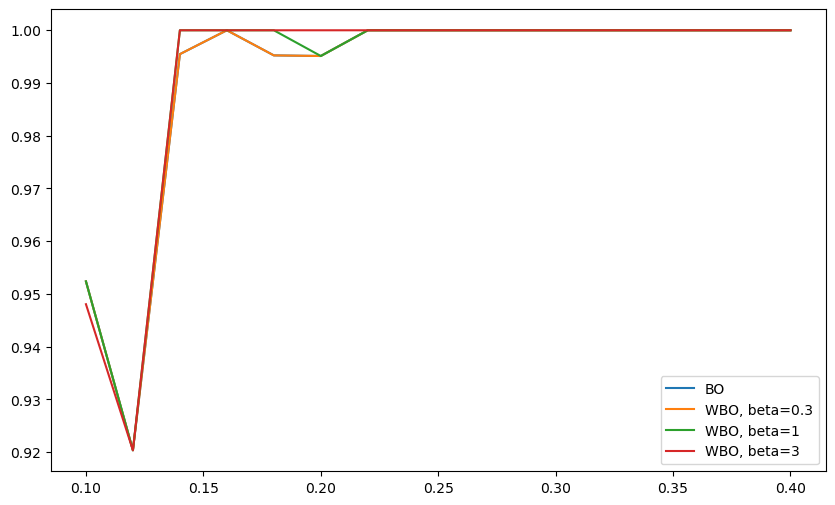

In [285]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(tr_sizes, acc_bo, label='BO')
for beta in [0.3, 1, 3]:
    plt.plot(tr_sizes, acc_wbo[beta], label=f'WBO, beta={beta}')
plt.legend()

# Experiment 2
Here we show what happens if we repeat the experiment above multiple times, and we average the results.


In [256]:
mean_acc_bo = []
std_acc_bo = []
betas = [0.1, 0.3, 1, 3, 10]
mean_acc_wbo = {beta: ([], []) for beta in betas}

tr_sizes = [0.1, 0.15, 0.2, 0.25, 0.3]

for training_size in tr_sizes:
    all_acc_bo = []
    all_acc_wbo = {beta: [] for beta in betas}
    for seed in range(20):
        X_train, X_test, y_train, y_test = get_X_y(X, y, seed=seed, size=training_size)
        VS = generate_version_space(X_train, y_train, full_rule_space, k=3)
        bo_acc = exact_uniform_bo(VS, X_test, y_test)
        all_acc_bo.append(bo_acc)
        for beta in betas:
            wbo_acc = exact_weighted_bo(VS, X_test, y_test, beta=beta)
            all_acc_wbo[beta].append(wbo_acc)

    mean_acc_bo.append(np.mean(all_acc_bo))
    std_acc_bo.append(np.std(all_acc_bo))

    for beta in betas:
        mean_acc_wbo[beta][0].append(np.mean(all_acc_wbo[beta]))
        mean_acc_wbo[beta][1].append(np.std(all_acc_wbo[beta]))


100%|██████████| 228031/228031 [00:07<00:00, 32146.62it/s]


[BO] TR=0.1 0.9177489177489179 +- 0.03761503722290642 (N=20)
[BO] TR=0.15 0.9706422018348624 +- 0.037362096686783905 (N=20)
[BO] TR=0.2 0.9860975609756097 +- 0.037509467375212886 (N=20)
[BO] TR=0.25 1.0 +- 0.0 (N=20)
[BO] TR=0.3 1.0 +- 0.0 (N=20)
[wBO, beta=3] TR=0.1 0.9158008658008658 +- 0.03959264381423423 (N=20)
[wBO, beta=3] TR=0.15 0.9722477064220184 +- 0.03598725447487402 (N=20)
[wBO, beta=3] TR=0.2 0.9887804878048779 +- 0.02882179755458038 (N=20)
[wBO, beta=3] TR=0.25 1.0 +- 0.0 (N=20)
[wBO, beta=3] TR=0.3 1.0 +- 0.0 (N=20)


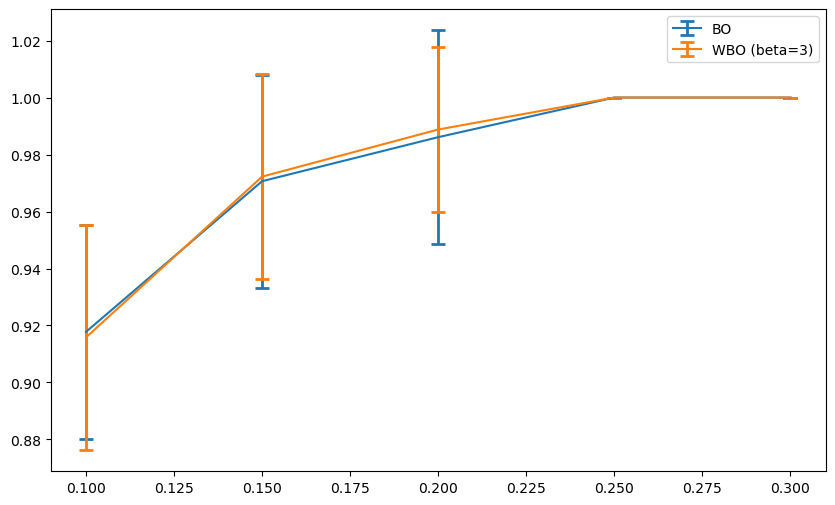

In [258]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))

# plot with stds
plt.errorbar(tr_sizes, mean_acc_bo, yerr=std_acc_bo, label="BO", capsize=5, capthick=2, elinewidth=2)
for tr_size, mu, std in zip(tr_sizes, mean_acc_bo, std_acc_bo):
    print(f"[BO] TR={tr_size} {mu} +- {std} (N={len(all_acc_bo)})")
for beta in [3]:
    plt.errorbar(tr_sizes, mean_acc_wbo[beta][0], yerr=mean_acc_wbo[beta][1], label="WBO (beta={})".format(beta), capsize=5, capthick=2, elinewidth=2)
    for tr_size, mu, std in zip(tr_sizes, mean_acc_wbo[beta][0], mean_acc_wbo[beta][1]):
        print(f"[wBO, beta={beta}] TR={tr_size} {mu} +- {std} (N={len(all_acc_bo)})")
plt.legend()

$$p(h) = \sum_z p(h,z) p(z)$$

sampling di 100 esempi; valutiamo probabilità di h su questi 100 esempi.

prendi tanti sottoinsiemi di 100 esempi, vedi quanto spesso viene fuori h.

data una qualsiasi tabella di verità, hai un numero esponenziale di possibili tasks. 2^(2^d) = M tabelle di verità su d features.

data una tabella di verità qualsiasi, ogni ipotesi/ruleset può essere vero o falso con probabilità 0.5.

fissato un task/tabella di verità, hai un numero di ipotesi che verificano il task che è il 50% del totale (molte complesse).

e.g, x1 -> y, x1 -> not y.

x1 and x2 -> y ;

00 ?
01 ?
10 ?
11 1

se esegui find-rs, vedi che quelli che prende sono sempre alcune (non quelle più complesse...).

se invece andassi a prendere una qualsiasi...

task qualsiasi => find-rs => dnf
vs => dnf

ti aspetti che find-rs ne trovi una più semplice rispetto a uniforme.

find-rs troverà una semplice del vs.

sarebbe carino e scoprire che find-rs ha un bias migliore, magari...

ci sarà un iperparametro per non accettare assolutamente errori?

p(h) => prior su ipotesi semplici
p(D|h) = 0 quando h non è consistente con D, unif altr.


I'm not sure on how to interpret the results.

* On one hand, we say that the Bayes Optimal Classifier should outperform every other classifier on average.
* On the other hand, it seems that the weighted version space sampling outperforms the uniform one on tr_size>0.1.

My question is: what exactly means "on average"?

on average means considering all the possible training sets? Hence, we are biased towards solving better the easy training sets and worse the hard ones?

In [40]:
1 - y_test.mean()

0.6302083333333333

# Old code

Here the strategies were implemented using sampling.

In [105]:
import random
from sklearn.metrics import accuracy_score


def uniform_bp(T=3, iters=10000, return_sample=False):
    accuracies = []
    for i in range(iters):
        # sample from VS
        uniform_sample = random.choices(list(VS), k=T)
        y_pred = np.array([sum([any([r.covers(x) for r in h]) for h in uniform_sample]) >= T // 2 for x in X_test])

        acc = accuracy_score(y_pred, y_test)
        accuracies.append(acc)
    print("(beta={}, unif) {} +- {} (N={})".format(0, np.mean(accuracies), np.std(accuracies), iters))
    if return_sample:
        return uniform_sample
    return np.mean(accuracies), np.std(accuracies)

In [106]:
def weighted_bp(T=3, beta=10, iters=10000, return_sample=False):
    accuracies = []
    for i in range(iters):
        p = np.array([np.exp(-beta * len(h)) for h in VS])
        p = p / sum(p)
        weighted_sample = random.choices(list(VS), k=T, weights=p)
        y_pred = np.array([sum([any([r.covers(x) for r in h]) for h in weighted_sample]) >= T // 2 for x in X_test])

        acc = accuracy_score(y_pred, y_test)
        accuracies.append(acc)
    print("(beta={}) {} +- {} (N={})".format(beta, np.mean(accuracies), np.std(accuracies), iters))
    if return_sample:
        return weighted_sample
    return np.mean(accuracies), np.std(accuracies)

Using uniform sampling, we can see many spurious rules.

246 dnf
nella versione uniform, calcoli per ogni dnf +1/-1 sul test per ogni esempio.

In [107]:
for t in [10, 20, 50, 100, 300, 1000]:
    uniform_bp(T=t, return_sample=True)

(beta=0, unif) 0.6816277056277057 +- 0.06451614712327404 (N=10000)


[(X[1] == 1 ^ X[2] == 1,
  X[0] == 0 ^ X[1] == 1,
  X[1] == 1 ^ X[4] == 0 ^ X[6] == 1),
 (X[0] == 0 ^ X[6] == 1 ^ X[7] == 1,
  X[0] == 0 ^ X[1] == 1 ^ X[2] == 0,
  X[1] == 1 ^ X[2] == 1 ^ X[3] == 0),
 (X[0] == 0 ^ X[5] == 1 ^ X[6] == 1,
  X[0] == 0 ^ X[1] == 1,
  X[1] == 1 ^ X[2] == 1 ^ X[3] == 0)]

Using weighted sampling, we get a much better result.

In [108]:
weighted_bp(T=3, return_sample=True)

(beta=10) 0.7442311688311689 +- 0.07590550519911578 (N=10000)


[(X[0] == 1 ^ X[2] == 1 ^ X[7] == 1, X[0] == 0 ^ X[1] == 1),
 (X[0] == 1 ^ X[2] == 1 ^ X[3] == 0, X[0] == 0 ^ X[1] == 1),
 (X[0] == 0 ^ X[1] == 1, X[1] == 1 ^ X[2] == 1 ^ X[3] == 0)]

In [114]:
for t in range(2, 11):
    weighted_bp(T=t, iters=1000, beta=5)

(beta=5) 0.7283766233766233 +- 0.07834899584920114 (N=1000)
(beta=5) 0.7133593073593073 +- 0.07411025353471022 (N=1000)
(beta=5) 0.753939393939394 +- 0.06417950034444651 (N=1000)
(beta=5) 0.7475584415584415 +- 0.06249880027333748 (N=1000)
(beta=5) 0.7583333333333333 +- 0.05575958813689897 (N=1000)
(beta=5) 0.7528268398268398 +- 0.05473059882328468 (N=1000)
(beta=5) 0.7576103896103896 +- 0.051963189713604446 (N=1000)
(beta=5) 0.7533463203463203 +- 0.048966085569791935 (N=1000)
(beta=5) 0.753974025974026 +- 0.04576430753988976 (N=1000)


In [112]:
for t in [10, 20, 50, 100, 300, 1000]:
    weighted_bp(T=t, iters=1000, beta=5)

(beta=5) 0.7561688311688312 +- 0.04434628632787227 (N=1000)
(beta=5) 0.7508528138528138 +- 0.03943843902137128 (N=1000)
(beta=5) 0.7422294372294372 +- 0.031211483262869388 (N=1000)
(beta=5) 0.7380692640692641 +- 0.027666356095609662 (N=1000)
(beta=5) 0.7290346320346319 +- 0.018555907802117237 (N=1000)
(beta=5) 0.7230173160173159 +- 0.008887342564287009 (N=1000)


The results confirm our hypothesis. Using the uniform sampling we already get really good results, but they are further improved by using the weighted sampling.

(beta=0, unif) 0.9985 +- 0.008529361054615995 (N=1000)
(beta=0, unif) 0.99802 +- 0.010113337727970927 (N=1000)
(beta=0, unif) 0.99998 +- 0.000446766158073774 (N=1000)
(beta=0, unif) 0.99997 +- 0.0005469003565550131 (N=1000)
(beta=5) 0.9991500000000001 +- 0.00646355165524343 (N=1000)
(beta=5) 0.9991 +- 0.006647555941848108 (N=1000)
(beta=5) 1.0 +- 0.0 (N=1000)
(beta=5) 1.0 +- 0.0 (N=1000)


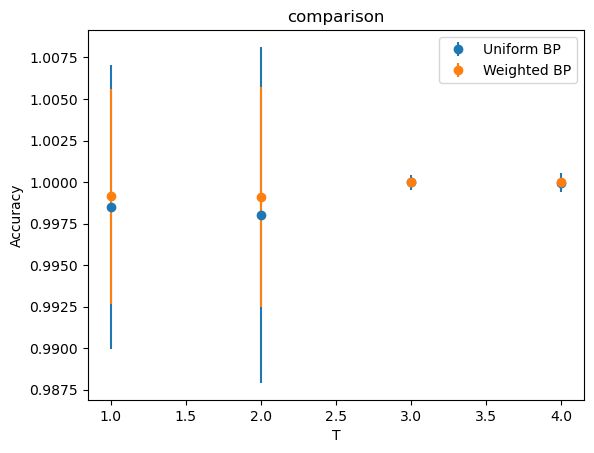

In [91]:
# create a plot with std error bars

import matplotlib.pyplot as plt


def plot_results(results, title):
    means = [r[0] for r in results]
    stds = [r[1] for r in results]
    plt.errorbar(range(1, len(means) + 1), np.array(means), yerr=stds, fmt='o', label=title)


# set y scale to log
# plt.yscale('log')
plot_results([uniform_bp(t, iters=1000) for t in range(2, 6)], "Uniform BP")
plot_results([weighted_bp(t, iters=1000, beta=5) for t in range(2, 6)], "Weighted BP")
plt.title('comparison')
plt.xlabel("T")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


D1 = [...]
D2 = D1 or x3=0
D3 = D1 or x3=1

guarda cambiando il numero di esempi. con pochi esempi cosa succede?

quando hai più esempi di training, puoi usare un beta più grande.
quando hai pochi esempi, beta più piccolo è meglio.